# Capstone 2
## <span style="color:green">Spotify x Billboard 'Hit' Predictor</span> 

With the emergence of social media platforms in the late 1990s, the popularity of independent artists (musicians without record label contracts/representation) and single-song production has risen. As a result, revenues in the music industry have declined causing many artists to reconsider the benefits of partnership with record labels.  This sentiment has pressured executives at record label companies to consider two propositions to remain competitive with independent artists, maintain their current client base, and attract new clients: assist in developing strong social media presence, or <u>develop a data-driven model capable of identifying songs worthy of Billboard status (i.e. resulting in increased streams and revenue).</u>  

Success criterion for the analysis will be established by:

<li> Identification of song attributes that distinguish Billboard success ('Hit' or 'Flop') </li>
<li> Building an model that can accurately (accuracy of at least 75%) predict a ‘Hit Song’  </li>
    
Songs were analyzed from three decades (1990s, 2000s, and 2010s) to determine which song features create hits, whether these features change over time, and whether an accurate model can be constructed from these features.


### Step 1: <span style="color:green">Import Libraries</span> 
The following libraries and packages will be used throughout the analysis 

In [1]:
## Descriptive Stats 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

##Predictive Model
import statsmodels as sm
import sklearn 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, precision_score, recall_score

## remove warning messages 
import warnings
warnings.filterwarnings('ignore')

### Step 2: <span style="color:green">Load Data</span> 
Retrieve the data sets for 1990s, 2000s, and 2010s 

In [2]:
nineties = pd.DataFrame(pd.read_csv('dataset-of-90s.csv'))
thousands = pd.DataFrame(pd.read_csv('dataset-of-00s.csv'))
tens = pd.DataFrame(pd.read_csv('dataset-of-10s.csv'))

### Step 3: <span style="color:green">Data Cleansing/Preparartion</span> 
Combine data frames, check for nulls, check for duplicates, etc.

In [3]:
## adding a column for decade to each dataset

nineties['decade']= 1990
thousands['decade']= 2000
tens['decade']= 2010


In [4]:
## combine data frames and save to a new csv

all_songs = [nineties, thousands, tens]
df=pd.concat(all_songs)


df.to_csv('df.csv', index = False) ## create the new csv
df.groupby('decade').head(1) ## check that the new dataframe has each decade

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,1990
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368,0.00000,0.1590,0.532,133.061,196707,4,30.88059,13,1,2000
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.020,0.00000,0.0828,0.706,108.029,188493,4,41.18681,10,1,2010


In [5]:
## check for nulls and duplicates to determine if the data needs to be cleaned
pd.isnull(df).sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
decade              0
dtype: int64

In [6]:
## Drop any duplicate rows based on track title and corresponding artist
df = df.drop_duplicates(subset=['track', 'artist'],keep='first')


No nulls, and the duplicate Song/Artist rows have been removed! 
Now let's convert duration_ms into minutes  

In [7]:
## Converting to minutes will make the scale of duration times a little easier to work with than milliseconds
df['duration_min']=round(df['duration_ms']/1000/60, 2)
df['duration_min']

0       2.65
1       6.46
2       3.95
3       6.27
4       7.18
        ... 
6393    2.51
6394    2.53
6395    3.80
6396    3.56
6397    5.69
Name: duration_min, Length: 17362, dtype: float64

Now lets generate a list of variables to be analyzed from the column names. 

In [8]:
df.columns 

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'decade', 'duration_min'],
      dtype='object')

Create a list of variables using Spotify's features (retrieved from https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) to be reused throughout the analysis.

In [9]:
spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']


## Descriptive Statistics
### Step 4: <span style="color:green">Preliminary Observations</span> 
First we'll look at the dataframe as a whole before dividing into two dataframes: Hits vs Flops (target = 1 or 0). 

In [10]:
## Preliminary descriptive statistics
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_min
count,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,1.736200e+04,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000
mean,0.559860,0.655534,5.269036,-8.368586,0.652632,0.088807,0.240249,0.157978,0.196683,0.485989,121.053226,2.494776e+05,3.923050,40.964088,10.795473,0.502246,2000.385900,4.157976
std,0.187469,0.246079,3.563331,5.302304,0.476148,0.092832,0.307832,0.308222,0.167195,0.255124,29.909889,1.119149e+05,0.378197,19.964160,4.744401,0.500009,8.174183,1.865268
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022000,0.000000,0.000000,0.013000,0.000000,34.535000,1.592000e+04,0.000000,0.000000,1.000000,0.000000,1990.000000,0.270000
25%,0.438000,0.505000,2.000000,-9.919000,0.000000,0.035700,0.009080,0.000000,0.093800,0.278250,97.149000,1.997632e+05,4.000000,27.902563,8.000000,0.000000,1990.000000,3.330000
50%,0.577000,0.699000,5.000000,-6.913500,1.000000,0.050400,0.082700,0.000044,0.128000,0.487000,119.876000,2.331265e+05,4.000000,36.271890,10.000000,1.000000,2000.000000,3.890000
75%,0.697000,0.856000,8.000000,-5.036000,1.000000,0.096700,0.378750,0.058800,0.257000,0.690000,140.003000,2.763132e+05,4.000000,48.324433,12.000000,1.000000,2010.000000,4.607500
max,0.986000,0.999000,11.000000,1.137000,1.000000,0.956000,0.996000,0.998000,0.992000,0.996000,217.872000,4.170227e+06,5.000000,262.615400,169.000000,1.000000,2010.000000,69.500000


Now let's compare the means for hit songs and flop songs, as well as their standard deviations, specifically using Spotify's metrics.

In [11]:
df_hits = df[spotify].loc[df['target']==1]
df_flops = df[spotify].loc[df['target']==0]

hits_mean = pd.DataFrame(df_hits.describe().loc['mean'])
flops_mean = pd.DataFrame(df_flops.describe().loc['mean'])

hits_std= pd.DataFrame(df_hits.describe().loc['std'])
flops_std = pd.DataFrame(df_flops.describe().loc['std'])


diff_per = pd.DataFrame((abs((hits_mean - flops_mean)/hits_mean)*100))
diff_per2 = pd.DataFrame((abs((hits_std - flops_std)/hits_std)*100))
joined_mean = pd.concat([hits_mean,flops_mean, hits_std, flops_std, diff_per, diff_per2], axis=1)
joined_mean.columns=['Hit Mean', 'Flop Mean', 'Hit StDev', 'Flop StDev', 'Percent Difference Mean', 'Percent Difference Stdev']

joined_mean.sort_values(by='Percent Difference Mean', ascending=False)


,Hit Mean,Flop Mean,Hit StDev,Flop StDev,Percent Difference Mean,Percent Difference Stdev
instrumentalness,0.014529,0.302723,0.084454,0.376768,1983.614351,346.121682
acousticness,0.160380,0.320838,0.198031,0.371327,100.049299,87.509247
loudness,-6.650014,-10.102669,2.708912,6.564568,51.919532,142.332319
danceability,0.640398,0.478594,0.144494,0.190770,25.266150,32.026475
valence,0.540387,0.431101,0.226222,0.270433,20.223705,19.543246
liveness,0.183044,0.210444,0.147126,0.184243,14.969405,25.228099
speechiness,0.095366,0.082189,0.099744,0.084786,13.817141,14.996699
energy,0.684383,0.626425,0.172946,0.299660,8.468638,73.267250
duration_min,3.997930,4.319467,0.822691,2.501079,8.042575,204.012022
mode,0.670298,0.634807,0.470132,0.481512,5.294869,2.420682


Here we can see a difference between the means of features of Hit songs vs Flop songs, especially in terms of Instrumentalness, Acousticness, Loudness, Danceability, and Valence (in descending order of percent difference). 

### Step 5: <span style="color:green">Visualization</span> 
We've started uncovering differences between the Hit and Flop data sets - let's investigate further making use of some visualization techniques:

#### Box Plots
Using box plots, we'll observe the variation in the distribution of data and see if there are any notable trends distinguishing Hits from Flops.

First we have all feaures that have values ranging from 0 to 1.

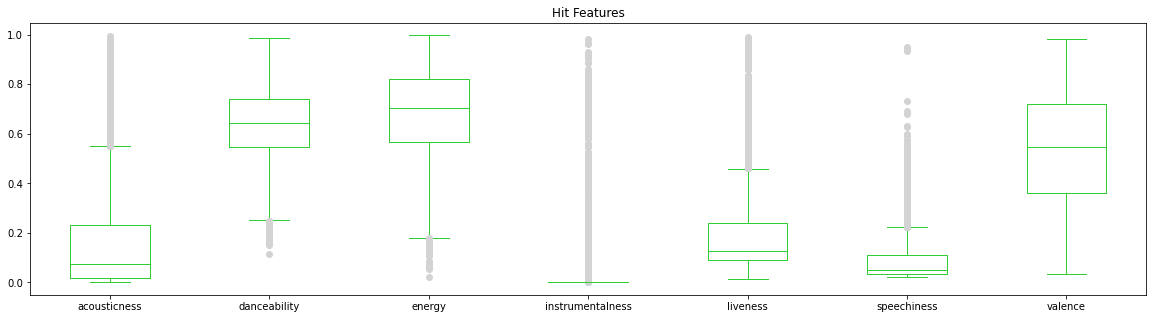

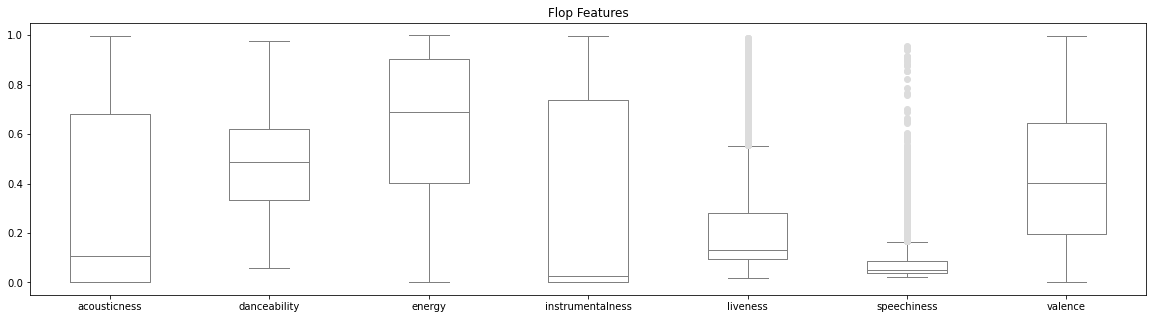

In [12]:
##To make the box plots more readable, I will break up the features based on their range of values and plot them accordingly

## The first box plots will be grouped by Hit vs Flop and display all features which have values in the range from 0 to 1

range_var= ['acousticness', 'danceability', 'energy', 'instrumentalness',
           'liveness', 'speechiness', 'valence']


mpl.rcParams['figure.figsize']=(20,5)

def box_plot(variable):
    df_hits[variable].plot(kind='box',color='limegreen', sym='lightgrey')
    plt.title('Hit Features')
    df_flops[variable].plot(kind='box', color='grey', sym = 'gainsboro')
    plt.title('Flop Features')

box_plot(range_var)








The following features are plotted on separate figures as their scale differs vastly from others. 

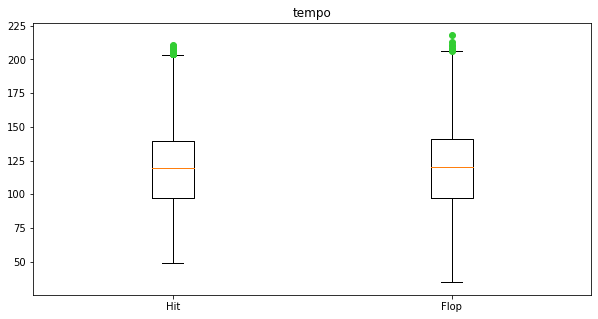

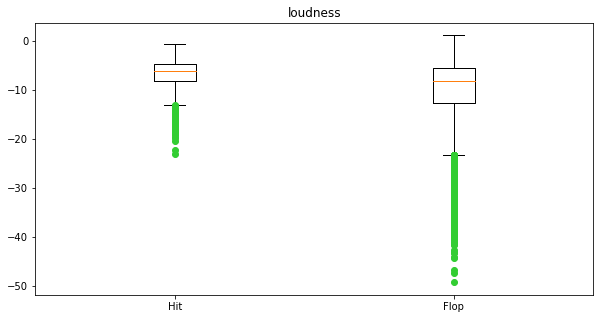

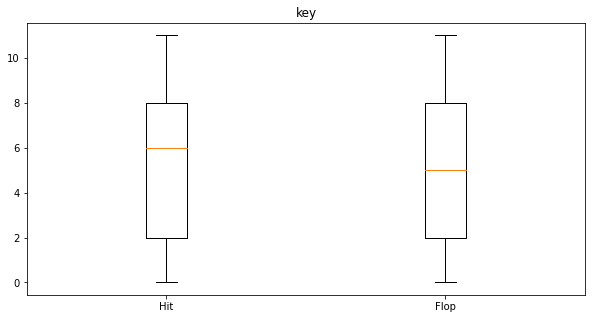

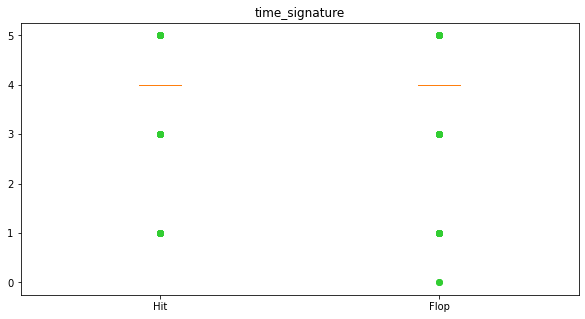

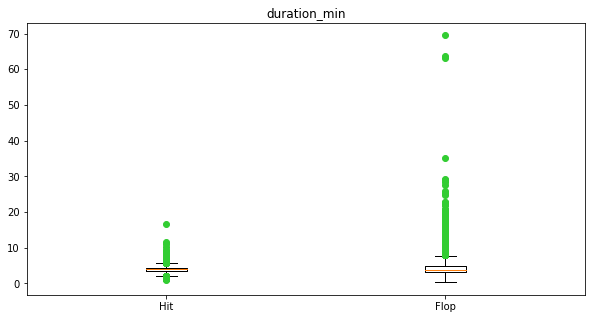

In [13]:
## Since these featuers have such different scales, I will create a function to compare the box plots of
## Hit vs Flop for each feature instead of plotting all features at once and separating by Hit vs Flop

other = ['tempo', 'loudness', 'key', 'time_signature', 'duration_min']

def box_plot(variable):
    label=[variable]
    fig, ax= plt.subplots(figsize=(10,5))
    ax.boxplot([df_hits[variable], df_flops[variable]], sym='limegreen')
    ax.set_xticklabels(['Hit', 'Flop'])
    ax.set_title(variable)
    
for variable in other:
    box_plot(variable)

Let's confirm our findings/suspicions so far with a more readable observation of the medians:

In [14]:
hit_med= pd.DataFrame(df_hits.median())
flop_med= pd.DataFrame(df_flops.median())
medians = pd.concat([hit_med, flop_med], axis = 1)
medians.columns=['Hit Median', 'Flop Median']
medians.sort_index(ascending=True)


,Hit Median,Flop Median
acousticness,0.0762,0.1070
danceability,0.6450,0.4850
duration_min,3.9000,3.8700
energy,0.7040,0.6910
instrumentalness,0.0000,0.0274
key,6.0000,5.0000
liveness,0.1260,0.1300
loudness,-6.1420,-8.1315
mode,1.0000,1.0000
speechiness,0.0491,0.0513


We can see some (marginal) differences between the hits and flops. Namely Hits have higher median danceability, duration, energy, key, loudness, and valence. By contrast, medians for acousticness, tempo, liveness, and speechiness are lower. A more in depth look at instrumentalness may be required. 

#### Histograms 

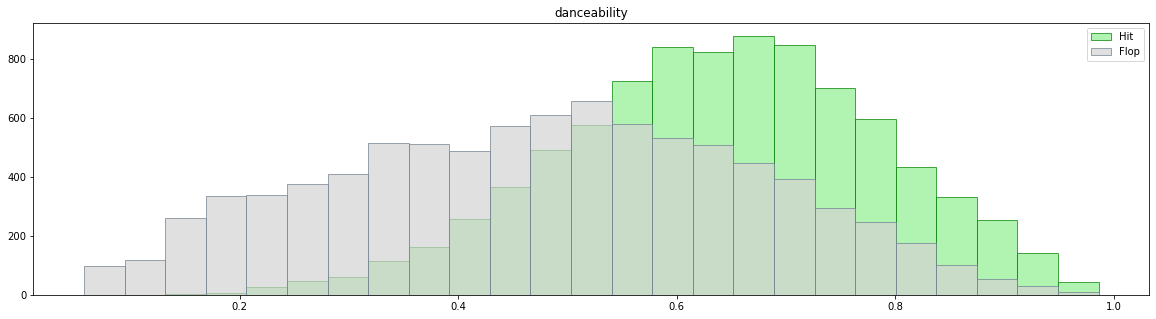

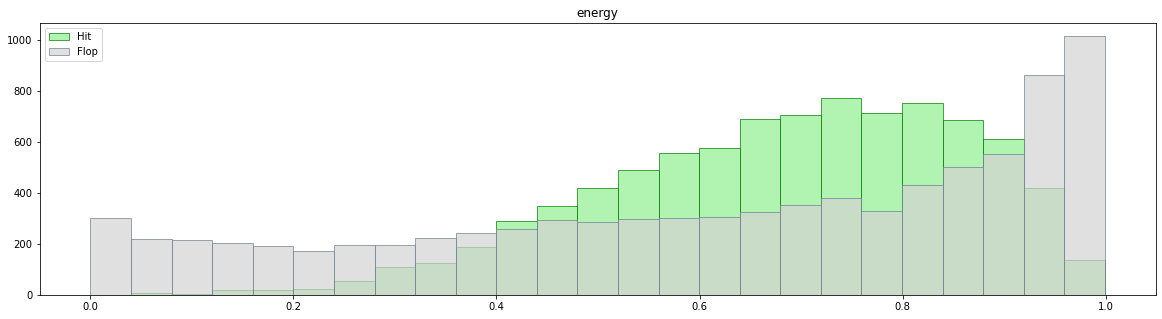

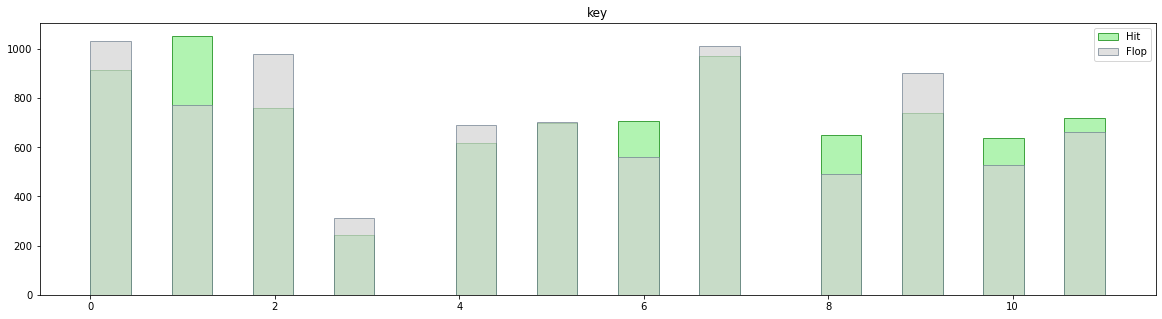

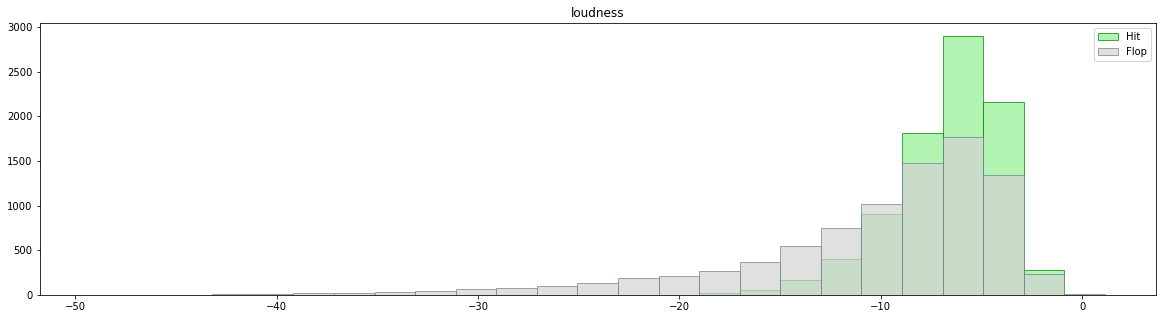

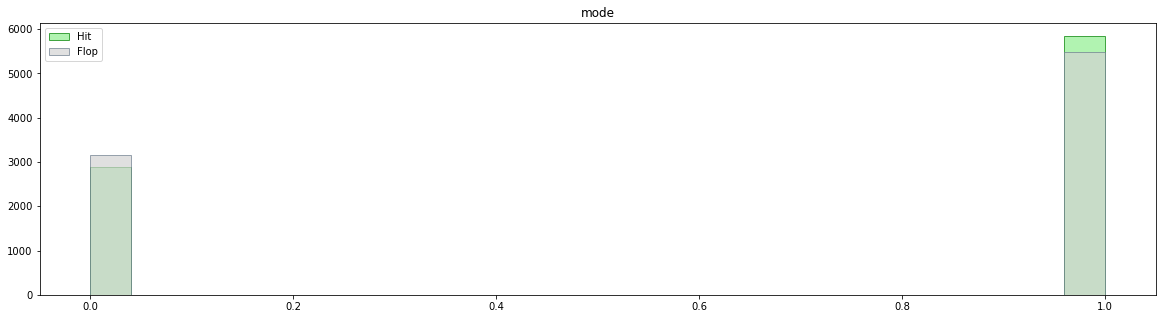

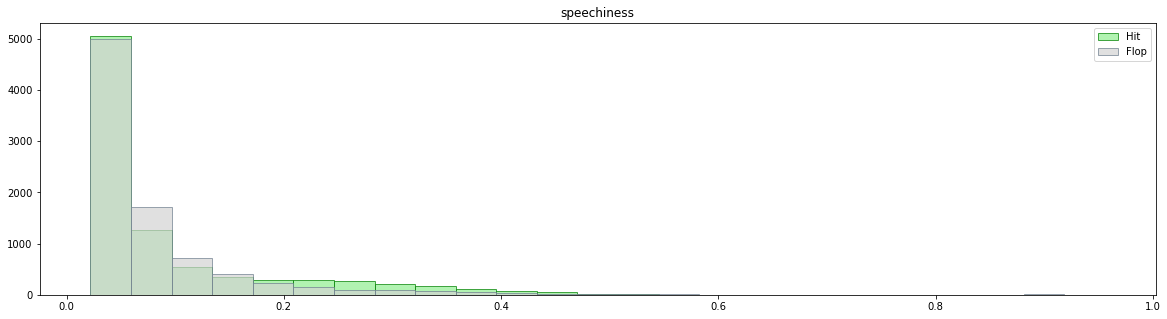

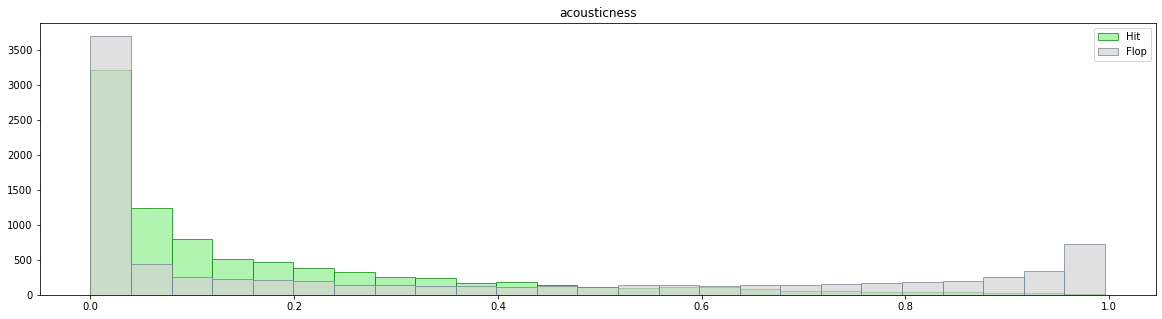

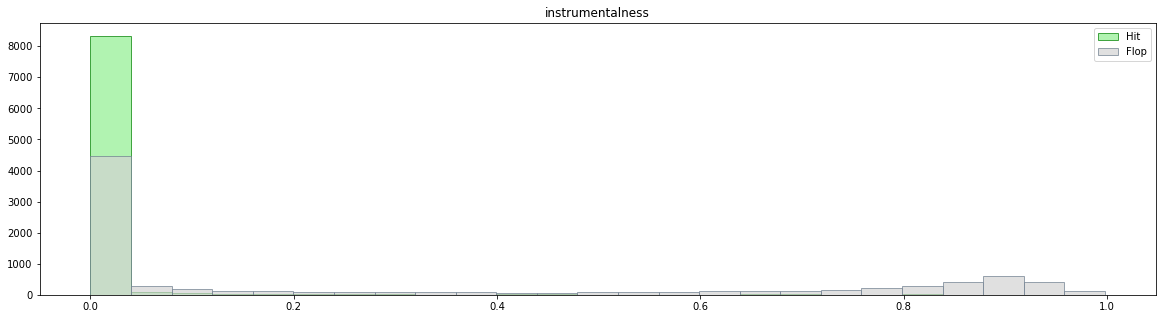

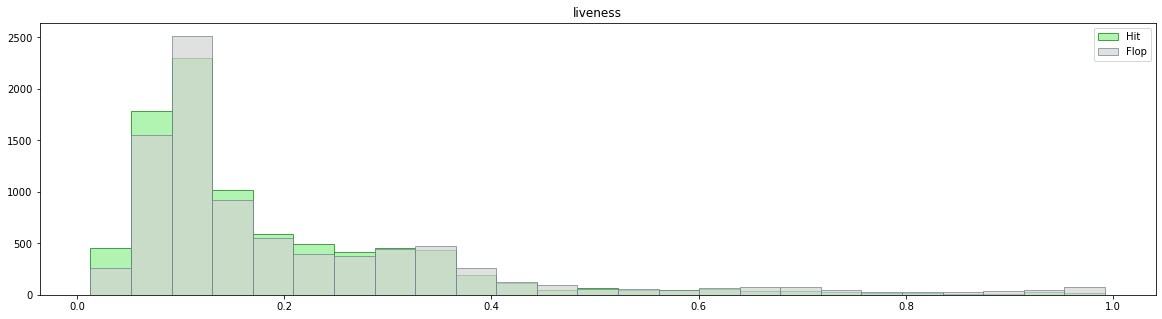

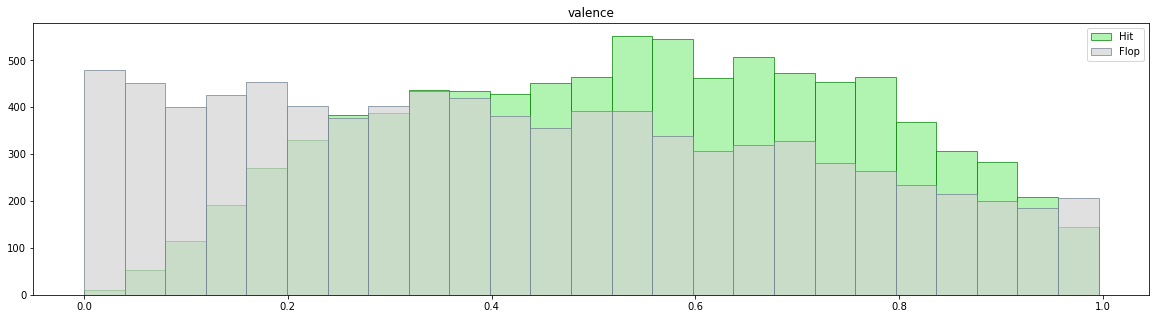

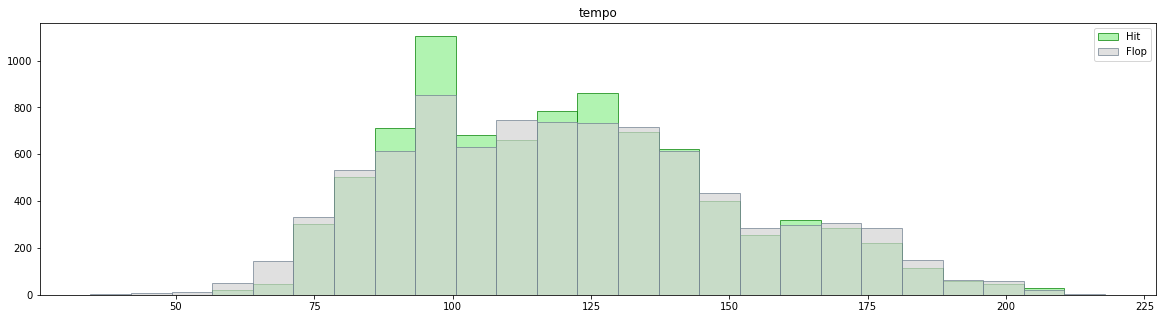

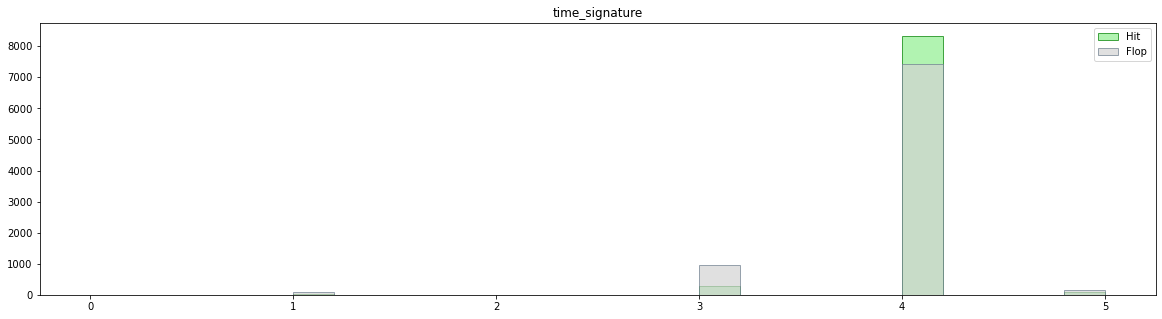

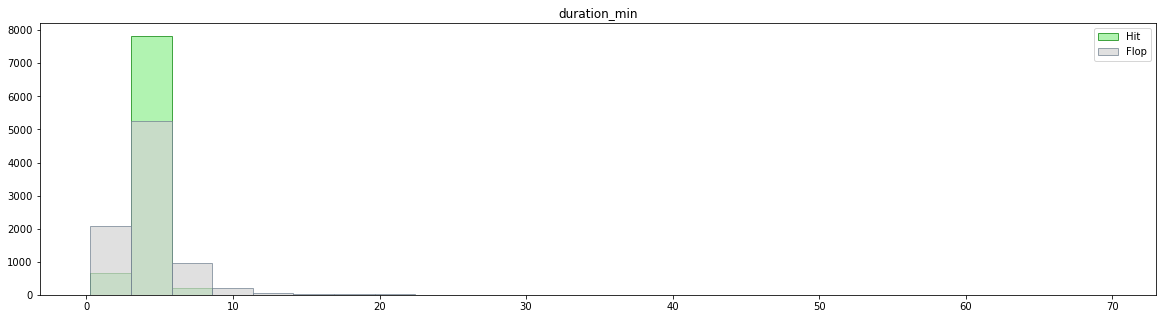

In [15]:
spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']



def hist_plot(variable):
        bins = 25
        bins = np.histogram(np.hstack((df_hits[variable], df_flops[variable])), bins=bins)[1]
        plt.hist(df_hits[variable], label='Hit', bins = bins, alpha=0.7, color='lightgreen', edgecolor='green')
        plt.hist(df_flops[variable], label='Flop', alpha=0.7, bins = bins, color='lightgrey', edgecolor='slategrey')
        plt.title(variable)
        plt.legend()
        plt.show()

for variable in spotify:
    hist_plot(variable)
    

The most insightful histograms would be danceability, loudness, valence, energy, acousticness, and instrumentalness. Danceability and Loudness both demonstrate a (mostly) central tendency for Hits whereas Flops are more widespread. Instrumentalness is at the lower end for both Flops and Hits, but Flops does indicate *some* frequency at the higher end. Valence shows a rough mirror-image for Hits vs Flops, hence it *may* be an important variable to consider in the analysis. 

Based on the findings so far, I believe there is enough difference between Hit and Flop songs that we can build a model to predict if a hit song can be determined from our dataset.

## Inferential Statistics
### Step 6: <span style="color:green">Preliminary Correlations: Heatmap</span> 
Let's consider the dataframe as a whole and observe a correlation matrix of all features 

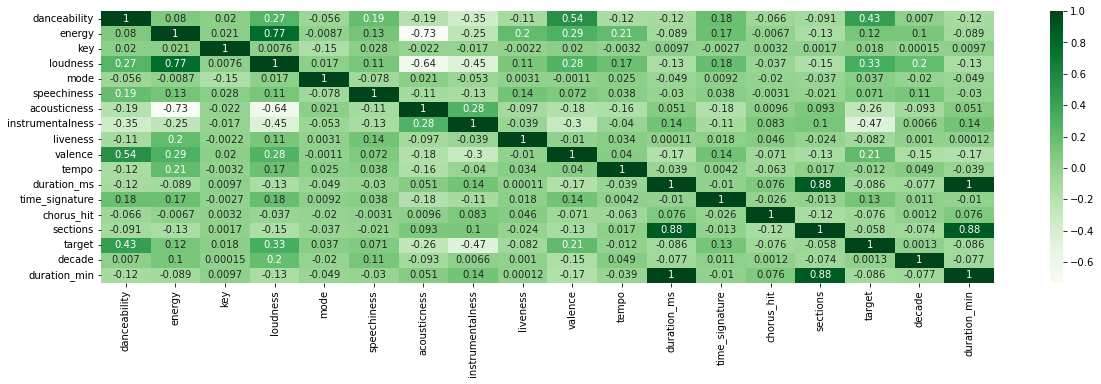

In [16]:
correlated= df.corr()
sns.heatmap(correlated, annot=True, cmap='Greens')
plt.show()

The features with the highest positive correlations to hit/flop (target = 1 or 0) are danceability (0.43), loudness (0.33), and valence (0.21). The features with the highest negative correlations to hit/flop are instrumentalness (-0.47) and acousticness (-0.26). 

### Step 7: <span style="color:green">Random Forest Classifier: Training </span> 
First, we'll set up and train the model:

In [164]:
## we'll be making use of the packages and libraries imported in Step 1 under Predictive Model
## we'll also be using the variables in the list Spotify as the explanatory variables

spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']

## Assign variables x and y as explanatory and dependent variables 

x = df[spotify]
y = df['target']

## split dataset into 70% train, 30% test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

## set Random Forest Classifier parameters, then fit it to the train data

rf = RandomForestClassifier(n_estimators = 400, random_state=0)
rf.fit(x_train, y_train)

print('Random Forest is trained.') ## depending on the number of estimators it may take while, 
                                   ## so adding a print statement allows me to know when it is ready


Random Forest is trained.


In [166]:
## use the fitted model create a prediction variable

y_pred = rf.predict(x_test)

print('Predictive model ready.')

Predictive model ready.


### Step 8: <span style="color:green">Evaluating Efficacy of the Model </span> 
#### RMSE
This will tell us the average distance between the predicted values from the model and the actual values in the dataset

In [167]:
rmse = mean_squared_error(y_test, y_pred)**0.5
print('RMSE of the model is ', rmse)


RMSE of the model is  0.4018100723342045


#### Metrics and Classification Report
Accuracy gives the ratio of true positive and true negative outcomes to all observations. Precision tells us what proportion of positive outcomes are correct. Recall tells us the ability to correctly predict pisitives from all actual positives.  

In [168]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

Metrics report:
Accuracy:  83.85 %
Precision:  82.12 %
Recall:  87.83 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2521
           1       0.82      0.88      0.85      2688

    accuracy                           0.84      5209
   macro avg       0.84      0.84      0.84      5209
weighted avg       0.84      0.84      0.84      5209



We have an overall accuracy of 83.85% as well as an accuracy f1-score of 0.84 - indicating based on the dataset from 1990s-present we can predict whether a song is a Hit or Flop with 84% accuracy. It also scored high in precision and recall. 

#### Confusion Matrix
To see a visual representation of true positives, true negatives, false positives and false negatives (as they were used in our reporting above) we can create a confusion matrix based on the model:

In [173]:
## create the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix generated.')

Confusion matrix generated.


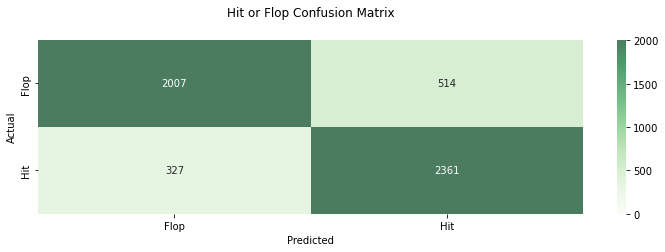

In [174]:
#create a figure/heatmap of the confusion matrix for a better visual

mpl.rcParams['figure.figsize']=(10,3)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="Greens" ,fmt='g', vmax=2007, vmin=0, alpha = 0.7)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Hit or Flop Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.xaxis.set_ticklabels(['Flop', 'Hit'])
ax.yaxis.set_ticklabels(['Flop', 'Hit'])
plt.show()

#### Feature Importance
Our preliminary theory was that of the features in our dataframe, based on the descriptive statistics, Danceability, Loudness, and Valence would have more importance given their positive correlation as well as  Acousticness and Instrumentalness given their negative correlation. 

We will use the feature importance metric to show which features are *most* predictive. 

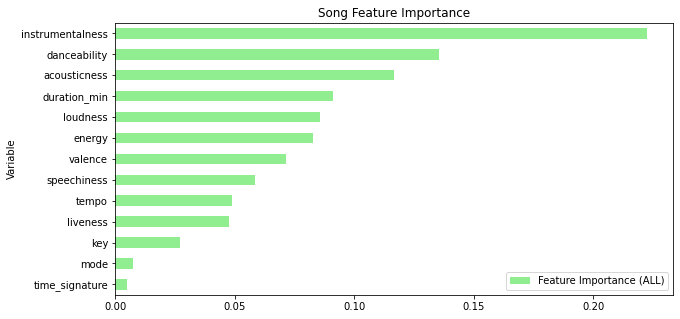

In [175]:
importance = pd.DataFrame(rf.feature_importances_)
features = pd.DataFrame(spotify)
imp_rf = pd.concat([features, importance], axis=1)
imp_rf.columns=['Variable', 'Feature Importance (ALL)']
imp_rf = imp_rf.set_index('Variable')
imp_rf = imp_rf.sort_values(by='Feature Importance (ALL)', ascending = True)


imp_rf.plot(kind='barh', color='lightgreen', figsize=(10,5))
plt.title('Song Feature Importance')
plt.show()

In [172]:
print(imp_rf.sort_values('Feature Importance (ALL)', ascending=False))

                  Feature Importance (ALL)
Variable                                  
instrumentalness                  0.222312
danceability                      0.135411
acousticness                      0.116611
duration_min                      0.091024
loudness                          0.085875
energy                            0.082927
valence                           0.071335
speechiness                       0.058428
tempo                             0.048820
liveness                          0.047522
key                               0.027034
mode                              0.007611
time_signature                    0.005089


For all decades, Instrumentalness, Danceability, Acousticness, Energy, and Duration were the greatest predictors of whether a song was a hit. As expected, Instrumentalness and Danceability appeared as top features (recall they were the highest negative and positive correlated variables). What was surprising was the importance of Duration 

In [176]:
## for later use, save the importance feature df to a new csv

All_Time = imp_rf
All_Time.to_csv('all_time.csv', index=False)

## <span style="color:green">What If: </span> 
### Can the model's efficacy be increased?

What about if we were to drop mode and time_signature from our independent variables? These two features have the lowest importance (below 0.01). How would this change our model?

In [177]:
x=df[spotify].drop(['mode','time_signature'], axis=1)
y=df['target']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)
rf = RandomForestClassifier(n_estimators=400, random_state=0)
rf.fit(x_train, y_train)

y_pred=rf.predict(x_test)

print('Model is ready')

Model is ready


In [178]:
rmse = mean_squared_error(y_test, y_pred)**0.5
print(rmse)

0.4039543452836305


In [179]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

Metrics report:
Accuracy:  83.68 %
Precision:  81.89 %
Recall:  87.8 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2521
           1       0.82      0.88      0.85      2688

    accuracy                           0.84      5209
   macro avg       0.84      0.84      0.84      5209
weighted avg       0.84      0.84      0.84      5209



Dropping the two least important features actually *negatively* affected to model. While it is minimal, the accuracy, precision, and recall decreased when Mode and Time Signature are removed from the explanatory variables. To have the best performing model, then, these features will need to remain in the list of independent variables. 

### Are there differences across each decade?

What if we were to subset our data back into the three decades and build a model around each of these timeframes - what differences in efficacy could we observe? Are there trends in feature importance?

In [180]:
### recreate the subsets from the df dataset (with nulls and repeats removed)

nineties = df[df['decade']==1990]
thousands = df[df['decade']==2000]
tens = df[df['decade']==2010]

In [181]:
## recall the spotify list of variables

spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']

#### Let's start with the 90s

In [189]:
## create the model for 1990s

x_90= nineties[spotify]
y_90= nineties['target']

x_train, x_test, y_train, y_test = train_test_split(x_90,y_90, test_size=0.3, random_state = 0)

rf = RandomForestClassifier(n_estimators = 400, random_state=0)
rf.fit(x_train, y_train)

y_pred_90=rf.predict(x_test)

print('RMSE is', mean_squared_error(y_test, y_pred_90)**.5)

accuracy = accuracy_score(y_test,y_pred_90)
precision = precision_score(y_test, y_pred_90)
recall = recall_score(y_test, y_pred_90)
report = classification_report(y_test, y_pred_90)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

RMSE is 0.37968484818544684
Metrics report:
Accuracy:  85.58 %
Precision:  84.99 %
Recall:  87.5 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       796
           1       0.85      0.88      0.86       848

    accuracy                           0.86      1644
   macro avg       0.86      0.86      0.86      1644
weighted avg       0.86      0.86      0.86      1644



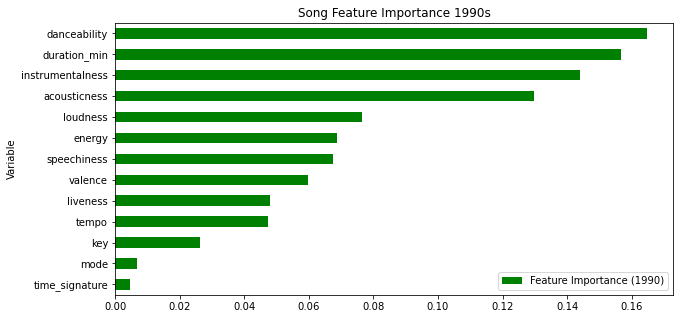

In [190]:
importance = pd.DataFrame(rf.feature_importances_)
features = pd.DataFrame(spotify)
imp_rf = pd.concat([features, importance], axis=1)
imp_rf.columns=['Variable', 'Feature Importance (1990)']
imp_rf = imp_rf.set_index('Variable')
imp_rf = imp_rf.sort_values(by='Feature Importance (1990)', ascending = True)


imp_rf.plot(kind='barh', color='green', figsize=(10,5))
plt.title('Song Feature Importance 1990s')
plt.show()

In [191]:
print(imp_rf.sort_values('Feature Importance (1990)', ascending=False))

                  Feature Importance (1990)
Variable                                   
danceability                       0.164550
duration_min                       0.156567
instrumentalness                   0.143847
acousticness                       0.129596
loudness                           0.076577
energy                             0.068840
speechiness                        0.067367
valence                            0.059797
liveness                           0.047839
tempo                              0.047378
key                                0.026345
mode                               0.006801
time_signature                     0.004496


In [192]:
the_90s = imp_rf
the_90s.to_csv('the_90s.csv', index=False)

#### Now let's work with the 2000s

In [193]:
## create the model for 2000s

x_00= thousands[spotify]
y_00= thousands['target']

x_train, x_test, y_train, y_test = train_test_split(x_00,y_00, test_size=0.3, random_state = 0)

rf = RandomForestClassifier(n_estimators=400,random_state=0)
rf.fit(x_train, y_train)

y_pred_00=rf.predict(x_test)

print('RMSE is', mean_squared_error(y_test, y_pred_00)**.5)

accuracy = accuracy_score(y_test,y_pred_00)
precision = precision_score(y_test, y_pred_00)
recall = recall_score(y_test, y_pred_00)
report = classification_report(y_test, y_pred_00)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

RMSE is 0.3982821917205437
Metrics report:
Accuracy:  84.14 %
Precision:  82.9 %
Recall:  86.95 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       840
           1       0.83      0.87      0.85       881

    accuracy                           0.84      1721
   macro avg       0.84      0.84      0.84      1721
weighted avg       0.84      0.84      0.84      1721



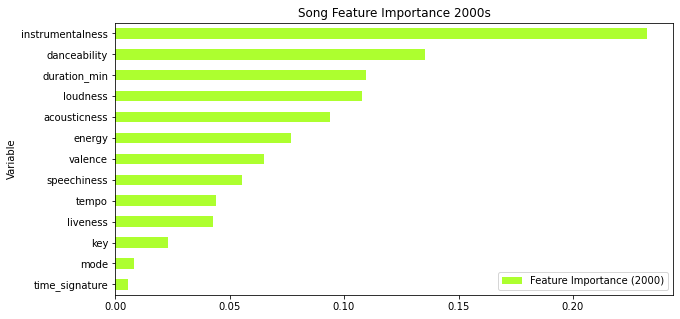

In [194]:
importance = pd.DataFrame(rf.feature_importances_)
features = pd.DataFrame(spotify)
imp_rf = pd.concat([features, importance], axis=1)
imp_rf.columns=['Variable', 'Feature Importance (2000)']
imp_rf = imp_rf.set_index('Variable')
imp_rf = imp_rf.sort_values(by='Feature Importance (2000)', ascending = True)


imp_rf.plot(kind='barh', color='greenyellow', figsize=(10,5))
plt.title('Song Feature Importance 2000s')
plt.show()

In [195]:
print(imp_rf.sort_values('Feature Importance (2000)', ascending=False))

                  Feature Importance (2000)
Variable                                   
instrumentalness                   0.232099
danceability                       0.135542
duration_min                       0.109381
loudness                           0.108008
acousticness                       0.093814
energy                             0.076992
valence                            0.065213
speechiness                        0.055319
tempo                              0.043874
liveness                           0.042660
key                                0.023083
mode                               0.008299
time_signature                     0.005717


In [196]:
the_00s = imp_rf
the_00s.to_csv('the_00s.csv', index=False)

#### Finallly we'll look at the 2010s

In [198]:
## create the model for 2010s

x_10= tens[spotify]
y_10= tens['target']

x_train, x_test, y_train, y_test = train_test_split(x_10,y_10, test_size=0.3, random_state = 0)

rf = RandomForestClassifier(n_estimators = 400,random_state=0)
rf.fit(x_train, y_train)

y_pred_10=rf.predict(x_test)

print('RMSE is', mean_squared_error(y_test, y_pred_10)**.5)

accuracy = accuracy_score(y_test,y_pred_10)
precision = precision_score(y_test, y_pred_10)
recall = recall_score(y_test, y_pred_10)
report = classification_report(y_test, y_pred_10)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

RMSE is 0.41646336503628284
Metrics report:
Accuracy:  82.66 %
Precision:  80.44 %
Recall:  88.0 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       887
           1       0.80      0.88      0.84       958

    accuracy                           0.83      1845
   macro avg       0.83      0.82      0.83      1845
weighted avg       0.83      0.83      0.83      1845



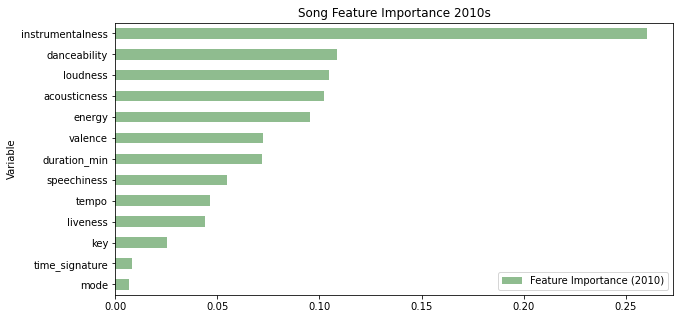

In [199]:
importance = pd.DataFrame(rf.feature_importances_)
features = pd.DataFrame(spotify)
imp_rf = pd.concat([features, importance], axis=1)
imp_rf.columns=['Variable', 'Feature Importance (2010)']
imp_rf = imp_rf.set_index('Variable')
imp_rf = imp_rf.sort_values(by='Feature Importance (2010)', ascending = True)


imp_rf.plot(kind='barh', color='darkseagreen', figsize=(10,5))
plt.title('Song Feature Importance 2010s')
plt.show()

In [200]:
print(imp_rf.sort_values('Feature Importance (2010)', ascending=False))

                  Feature Importance (2010)
Variable                                   
instrumentalness                   0.260005
danceability                       0.108563
loudness                           0.104776
acousticness                       0.102196
energy                             0.095184
valence                            0.072184
duration_min                       0.072118
speechiness                        0.054811
tempo                              0.046249
liveness                           0.043765
key                                0.025199
time_signature                     0.008160
mode                               0.006788


In [201]:
the_10s = imp_rf
the_10s.to_csv('the_10s.csv', index=False)

#### Now let's look at how feature importance has changed across the decades vs our all time model:

In [202]:
compare = pd.concat([All_Time, the_90s, the_00s, the_10s], axis=1)
compare.to_csv('comparison_if.csv', index=False)

compare.sort_values('Feature Importance (ALL)', ascending = False)

,Feature Importance (ALL),Feature Importance (1990),Feature Importance (2000),Feature Importance (2010)
Variable,,,,
instrumentalness,0.222312,0.143847,0.232099,0.260005
danceability,0.135411,0.164550,0.135542,0.108563
acousticness,0.116611,0.129596,0.093814,0.102196
duration_min,0.091024,0.156567,0.109381,0.072118
loudness,0.085875,0.076577,0.108008,0.104776
energy,0.082927,0.068840,0.076992,0.095184
valence,0.071335,0.059797,0.065213,0.072184
speechiness,0.058428,0.067367,0.055319,0.054811
tempo,0.048820,0.047378,0.043874,0.046249


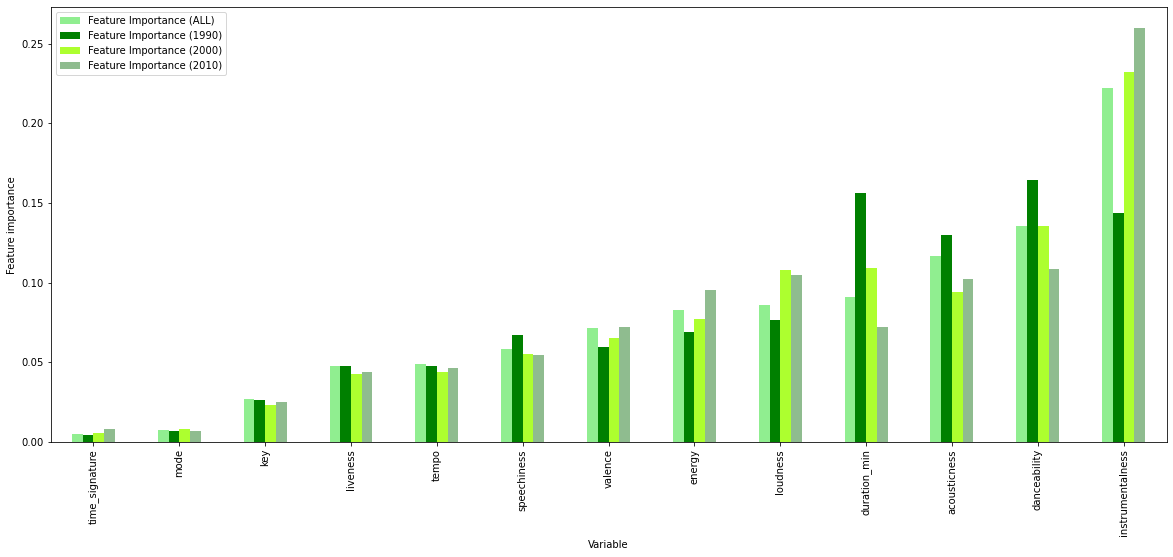

In [203]:
compare.plot(kind='bar', color = ('lightgreen','green','greenyellow','darkseagreen' ), figsize = (20,8))
plt.ylabel("Feature importance")
plt.show()

Based on the comparison dataframe, we see that overall Instrumentalness, Danceability, Acousticness, Duration, and Loudness have the greatest overall feature importance (with the exception of the 2010s where Energy has greater importance than Duration), however the degree of importance for these attributes varies across the decades.

For example: Instrumentalness, Loudness, Energy and Valence each increased from 1990s-2010s whereas Danceability, Acousticness, and Duration all decreased. The remaining variables remained fairly consistent across the decades. 